In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Methods

- We will build models reflecting three levels of available data
    - "Easy" is mostly data already available to the emergency dispatcher before the notification comes in, like month, day of week, hour, weather, urban/rural, 

# Setup

## Import Libraries

In [2]:
print ('Install Packages')

import sys, copy, math, time, os

print ('Python version: {}'.format(sys.version))

#from collections import Counter

import numpy as np
print ('NumPy version: {}'.format(np.__version__))
np.set_printoptions(suppress=True)

import scipy as sc
print ('SciPy version:  {}'.format(sc.__version__))

import tensorflow as tf
print ('TensorFlow version:  {}'.format(tf.__version__))
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

from tensorflow import keras
print ('Keras version:  {}'.format(keras.__version__))

from keras import layers
import keras.backend as K
#from keras.layers import IntegerLookup
#from keras.layers import Normalization
#from keras.layers import StringLookup
#from keras.utils import get_custom_objects
#from keras.utils import tf_utils

from keras.models import Sequential
from keras.layers import Dense

#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

import pandas as pd
print ('Pandas version:  {}'.format(pd.__version__))
pd.set_option('display.max_rows', 500)

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

import matplotlib.pyplot as plt
%matplotlib inline

# Library for reading Microsoft Access files
#import pandas_access as mdb

import sklearn
print ('SciKit-Learn version: {}'.format(sklearn.__version__))
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
#from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import imblearn
print ('Imbalanced-Learn version: {}'.format(imblearn.__version__))
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier

#!pip install pydot

# Set Randomness.  Copied from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
import random
#np.random.seed(42) # NumPy
#random.seed(42) # Python
#tf.random.set_seed(42) # Tensorflow

import warnings
warnings.filterwarnings('ignore')

print ('Finished Installing Packages')

Install Packages
Python version: 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
NumPy version: 1.24.2
SciPy version:  1.7.3


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version:  2.11.0
Keras version:  2.11.0
Pandas version:  1.5.3
SciKit-Learn version: 1.2.2
Imbalanced-Learn version: 0.10.1
Finished Installing Packages


In [3]:
def Chart_and_Plots(y_test, y_proba, y_pred, filename, title):
    
    Analyze_Prediction_2(y_test, y_proba, filename, title)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 6400)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 3200)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 1600)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 800)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 400)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 200)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 100)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 50)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 25)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 10)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 5)
    
    Plot_Prediction(y_test, y_proba, filename, title)
    Plot_Prediction_Wide(y_test, y_proba, filename, title)
#    print ("type(y_proba): ", type(y_proba))
    left = min(y_proba)
    right = max(y_proba)
#    print (left, right)
    Plot_Prediction_Zoom(y_test, y_proba, filename, title, left, right)
    Plot_Prediction_Zoom_Wide(y_test, y_proba, filename, title, left, right)

    ROC(y_test, y_proba, [], filename)
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)
    
    print ()
    

In [4]:
def Evaluate_Model(y_test, y_proba, y_pred, center, filename):
    print ('Evaluate_Model()')
    y_test = np.array(y_test)
    y_pred = [round(x) for x in y_proba]
    y_pred = np.array(y_pred)
#    print ('np.unique(y_proba) = ', np.unique(y_proba))
#    print ('np.unique(y_pred) = ', np.unique(y_pred))
    CM = confusion_matrix(y_test, y_pred)
#    print(CM)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_value = auc(fpr, tpr)
    f = open('./Analyze_Proba/ROC_AUC.csv', 'a')
    f.write('%s,%f\n' % (filename, auc_value) )
    f.close()
    
    CSV = [[filename, CM[0][0], CM[0][1], CM[1][0], CM[1][1], center, auc_value]]
    np.savetxt('./Confusion_Matrices/' + filename + '.csv', 
        CSV,
        delimiter =", ", 
        fmt ='% s'
              )
#    print ()
    CM = confusion_matrix(y_test, y_pred, normalize='all')
#    print(CM)
#    print ()

#    y_pred = y_pred.ravel()
#    y_test = tf.convert_to_tensor(y_test)
#    y_pred = tf.convert_to_tensor(y_pred)

#    print ('%.3f & Precision \cr ' %  Precision_Metric(y_test, y_pred).numpy())
#    print ('%.3f & Recall \cr ' %  Recall_Metric(y_test, y_pred).numpy())
#    print ('%.3f & F1 \cr ' %  F1_Metric(y_test, y_pred).numpy())



# Plots and Tables

## Plot Prediction

How to insert a .pgf plot into a \LaTeX document:

\begin{figure}
    \begin{center}
        \input{Plot.pgf}
    \end{center}
    \caption{A PGF histogram from \texttt{matplotlib}.}
\end{figure}


In [5]:
def Plot_Prediction(y_test, y_proba, filename, title):
    print ('Plot_Prediction()')
    print (filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [x/n for x in range (0, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)
    
    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    plt.xticks(
        ticks = [0, 2.5, 5, 7.5, 10], 
        labels = ['0.0', '0.25', '0.5', '0.75', '1.0'],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + filename + '_Pred.png')
    plt.show()
    plt.close()
    print ()


In [6]:
def Plot_Prediction_Zoom(y_test, y_proba, filename, title, left, right):
    print ('Plot_Prediction()')
    print (filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

    ticks = [0, 5, 10]
    num_prec = int(-(math.log10((right-left)/2)))+1
    num_prec = max(num_prec,2)
    
    if num_prec==2:
        labels = ["{:.2f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    
    
#    labels = [str(round(left + (right-left) * t/10,3)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred_Zoom.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred_Zoom.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + filename + '_Pred_Zoom.png')
    plt.show()
    plt.close()
    print ()


In [7]:
def Plot_Prediction_Zoom_Wide(y_test, y_proba, filename, title, left, right):
    print ('Plot_Prediction()')
    print (filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 20
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

#    ticks = [0, 2.5, 5, 7.5, 10]
    ticks = [0, 4, 8, 12, 16, 20]
    num_prec = int(-(math.log10((right-left)/4)))+1
    num_prec = max(num_prec,2)
#    print ("left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec")
#    print (left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec)
    
    if num_prec<3:
        labels = ["{:.2f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
#    labels = [str(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    
    
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred_Zoom_Wide.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred_Zoom_Wide.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + filename + '_Pred_Zoom_Wide.png')
    plt.show()
    plt.close()
    print ()


Plot_Prediction()
Test
./Images/Test_Pred_Wide.png


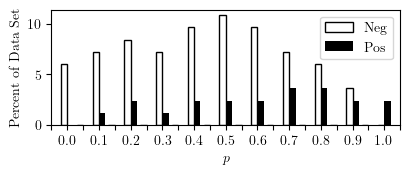

In [8]:
def Plot_Prediction_Wide(y_test, y_proba, filename, title):
    print ('Plot_Prediction()')
    print (filename)
    
#    print ('y_test = ', y_test)
#    print ('y_proba = ',y_proba)

#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    print ("A = pd.DataFrame(y_proba, columns=['HOSPITAL'])")
#    display(A)
#    print ("B = pd.DataFrame(y_test, columns=['HOSPITAL'])")
#    display(B)
#    print ("C = A[B['HOSPITAL']==0]")
#    display(C)
#    print ("D = A[B['HOSPITAL']==1]")
#    display(D)
    n = 20
#    bins= [x/n - 1/(2*n) for x in range (-1, n+3)]
    bins= [x/n for x in range (-1, n+1)]
#    print ('Bins = ', bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
#    print ("E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(E)
#    print ("F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(F)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)
#    print ("G = E.value_counts(sort=False)")
#    display(G)
#    print ("H = F.value_counts(sort=False)")
#    display(H)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100
#    print ("G = G/len(y_proba)*100")
#    display(G)
#    print ("H = H/len(y_proba)*100")
#    display(H)

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    ticks = [n/20*i for i in range (-1,22)]
#    print ('ticks = ', ticks)
    plt.xticks(
        ticks = ticks,
        labels = ['','0.0', '', '0.1', '', '0.2', '', '0.3', '', '0.4', '', '0.5', '', '0.6', '', '0.7', '', '0.8', '', '0.9', '', '1.0', ''],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred_Wide.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred_Wide.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + filename + '_Pred_Wide.png')
    plt.show()
    plt.close()
    print ()

def Test_Plot_Prediction_Wide():
    
    y_proba = (
        [0.0]*5 + 
        [0.0]*0 + 
        [0.1]*6 + 
        [0.1]*1 + 
        [0.2]*7 + 
        [0.2]*2 + 
        [0.3]*6 + 
        [0.3]*1 + 
        [0.4]*8 + 
        [0.4]*2 + 
        [0.5]*9 + 
        [0.5]*2 + 
        [0.6]*8 + 
        [0.6]*2 + 
        [0.7]*6 + 
        [0.7]*3 + 
        [0.8]*5 + 
        [0.8]*3 + 
        [0.9]*3 + 
        [0.9]*2 + 
        [1.0]*0 + 
        [1.0]*2 
    )
    y_test = (
        [0]*5 + 
        [1]*0 + 
        [0]*6 + 
        [1]*1 + 
        [0]*7 + 
        [1]*2 + 
        [0]*6 + 
        [1]*1 + 
        [0]*8 + 
        [1]*2 + 
        [0]*9 + 
        [1]*2 + 
        [0]*8 + 
        [1]*2 + 
        [0]*6 + 
        [1]*3 + 
        [0]*5 + 
        [1]*3 + 
        [0]*3 + 
        [1]*2 + 
        [0]*0 + 
        [1]*2 
    )
    Plot_Prediction_Wide(y_test, y_proba, 'Test', 'Test')
    
Test_Plot_Prediction_Wide()

## Switching between FP/TP and Precision

$$\text{Precision} = \frac{TP}{FP+TP}$$

$$\frac{1}{\text{Precision}} = \frac{FP+TP}{TP} = \frac{FP}{TP} + \frac{TP}{TP} = \frac{FP}{TP} +  1$$

$$\frac{FP}{TP} + 1 = \frac{1}{\text{Precision}}$$

$$\frac{FP}{TP} = \frac{1}{\text{Precision}} - 1 = \frac{1}{\text{Precision}} - \frac{\text{Precision}}{\text{Precision}}  = \frac{1 - \text{Precision}}{\text{Precision}}$$

- In a previous version I had wanted $FP/TP$ to equal either 2.0, 1.0, or 0.5, indicating that we were willing to send 2 unnecessary ambulances for each necessary one, etc.  
    - $FP/TP = 2.0$ corresponds to precision = 1/3
    - $FP/TP = 1.0$ corresponds to precision = 1/2
    - $FP/TP = 0.5$ corresponds to precision = 2/3

- Neg/Pos corresponds to marginal precision similarly

In [9]:
def Value_Counts_y_proba(y_proba, filename):
#    print ()
    print ('Value_Counts_y_proba')
#    print (type(y_proba))
    Y_proba = pd.Series(y_proba)
    A = Y_proba.value_counts().reset_index(drop=True)
    n = len(y_proba)
    nA = len(A)
#    display(Y_proba)
#    display(A)
    B = A.cumsum()
#    display(B)
#    print (B[10])
#    print ()
    cutoff_95 = B.sub(0.95*n).abs().idxmin() + 1
    cutoff_90 = B.sub(0.90*n).abs().idxmin() + 1
    cutoff_80 = B.sub(0.80*n).abs().idxmin() + 1
    m = Y_proba.min()
    M = Y_proba.max()
    print (n, nA)
    print (cutoff_95)
#    print ()

    n100 = min(100, len(B)-1)
    n200 = min(200, len(B)-1)
#    print ('n200 = ', n200)
    f = open('./Analyze_Proba/Value_Counts_y_proba.csv', 'a')
    f.write('%s,%d,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%0.4f,%0.4f\n' % (
        filename, n, nA, nA/n, 
        cutoff_95, cutoff_95/n,
        cutoff_90, cutoff_90/n,
        cutoff_80, cutoff_80/n,
        B[10], B[10]/n,
        B[20], B[20]/n,
        B[n100], B[n100]/n,
        B[n200], B[n200]/n,
        m,M,
    ))
    f.close()
    
    H = Y_proba.value_counts().head(100)
    Filename = './Analyze_Proba/' + filename + '_Value_Counts.csv'
    H.to_csv(Filename)
    
    
    print ('Finished')
    return 0
    
def Create_Files_for_Value_Counts_y_proba():
    f = open('./Analyze_Proba/Value_Counts_y_proba.csv', 'w')
    f.write("Filename,n,nUnique,nUnique/n,95%,95%/n,90%,90%/n,80%,80%/n,B[10],B[10]/n,B[20],B[20]/n,B[100],B[100]/n,B[200],B[200],min,max,\n")
    f.close()
    
#Create_Files_for_Value_Counts_y_proba()

def Create_Files_for_Lengths_of_fpr_tpr():
    f = open('./Analyze_Proba/Lengths_of_fpr_tpr.csv', 'w')
    f.write("Filename,len(y_proba),nUnique(y_proba),len(fpr),nUnique(fpr),len(tpr),nUnique(tpr),len(fpr tpr),nUnique(fpr tpr)\n")
    f.close()
    
def Create_Files_for_ROC_AUC():
    f = open('./Analyze_Proba/ROC_AUC.csv', 'w')
    f.write("Filename,ROC_AUC\n")
    f.close()
    
    
    
def Test_Value_Counts_y_proba():
    A = [5]*50 + [6]*20 + [i for i in range (10,40)]*2 + [i for i in range (100,400)]
    Value_Counts_y_proba(A, 'Test')

Test_Value_Counts_y_proba()

    


Value_Counts_y_proba
430 332
310
Finished


In [10]:
def Analyze_Prediction(y_test, y_proba, filename, title):
    print ('Analyze_Prediction()')
    print (filename)
    
#    Value_Counts_y_proba(y_proba, filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    print ('print (len(A), len(C), len(D), len(C) + len(D))')
#    print (len(A), len(C), len(D), len(C) + len(D))

    N = len(C)
    P = len(D)
    
    ##### 10 bins
    n = 10
    bins= [x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    Analyze = pd.DataFrame()
    Analyze['Neg'] = G
    Analyze['Pos'] = H
    Analyze['p'] = bins[1:]
#    Analyze['Neg/Pos'] = Analyze['Neg']/Analyze['Pos']
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = Analyze['Pos']/(Analyze['Pos'] + Analyze['Neg'])
    Analyze['TN'] = Analyze['Neg'].cumsum()
    Analyze['FP'] = N - Analyze['TN']
    Analyze['FN'] = Analyze['Pos'].cumsum()
    Analyze['TP'] = P - Analyze['FN']
#    Analyze['FP/TP'] = Analyze['FP']/Analyze['TP']
#    Analyze['FP+TP'] = Analyze['FP'] + Analyze['TP']
    Analyze['Prec'] = Analyze['TP']/(Analyze['FP'] + Analyze['TP'])
    Analyze['Rec'] =  Analyze['TP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$'] =  Analyze['FP']/(Analyze['FN'] + Analyze['TP'])
    
    Analyze['Neg']=Analyze['Neg'].apply('{:,}'.format)
    Analyze['Pos']=Analyze['Pos'].apply('{:,}'.format)
    Analyze['TN']=Analyze['TN'].apply('{:,}'.format)
    Analyze['FP']=Analyze['FP'].apply('{:,}'.format)
    Analyze['FN']=Analyze['FN'].apply('{:,}'.format)
    Analyze['TP']=Analyze['TP'].apply('{:,}'.format)
#    Analyze['FP+TP']=Analyze['FP+TP'].apply('{:,}'.format)
    
#    Analyze['Neg/Pos']=Analyze['Neg/Pos'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.2f}'.format)
#    Analyze['FP/TP']=Analyze['FP/TP'].apply('{:.2f}'.format)
    Analyze['Prec']=Analyze['Prec'].apply('{:.2f}'.format)
    Analyze['Rec']=Analyze['Rec'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$']=Analyze['$\\frac{\\text{FP}}{\\text{P}}$'].apply('{:.2f}'.format)
        
#    Analyze.index.name = 'p'
    Analyze.set_index('p', inplace=True)
#    print ('./Analyze_Proba/' + filename + '_10.tex')
#    print (len(y_proba))
#    display(Analyze)
    Analyze.to_csv('./Analyze_Proba/' + filename + '_10.csv', index=True)
    Analyze.to_latex(
        './Analyze_Proba/' + filename + '_10.tex', 
        index=True, 
        float_format="{:.2f}".format, 
        column_format='rrrcrrrrrrrrrrr',
        escape=False
    )



    ##### 20 bins
    n = 20
    bins= [x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    Analyze = pd.DataFrame()
    Analyze['Neg'] = G
    Analyze['Pos'] = H
    Analyze['p'] = bins[1:]
#    Analyze['Neg/Pos'] = Analyze['Neg']/Analyze['Pos']
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = Analyze['Pos']/(Analyze['Pos'] + Analyze['Neg'])
    Analyze['TN'] = Analyze['Neg'].cumsum()
    Analyze['FP'] = N - Analyze['TN']
    Analyze['FN'] = Analyze['Pos'].cumsum()
    Analyze['TP'] = P - Analyze['FN']
#    Analyze['FP/TP'] = Analyze['FP']/Analyze['TP']
#    Analyze['FP+TP'] = Analyze['FP'] + Analyze['TP']
    Analyze['Prec'] = Analyze['TP']/(Analyze['FP'] + Analyze['TP'])
    Analyze['Rec'] =  Analyze['TP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$'] =  Analyze['FP']/(Analyze['FN'] + Analyze['TP'])
    
    Analyze['Neg']=Analyze['Neg'].apply('{:,}'.format)
    Analyze['Pos']=Analyze['Pos'].apply('{:,}'.format)
    Analyze['TN']=Analyze['TN'].apply('{:,}'.format)
    Analyze['FP']=Analyze['FP'].apply('{:,}'.format)
    Analyze['FN']=Analyze['FN'].apply('{:,}'.format)
    Analyze['TP']=Analyze['TP'].apply('{:,}'.format)
#    Analyze['FP+TP']=Analyze['FP+TP'].apply('{:,}'.format)
    
#    Analyze['Neg/Pos']=Analyze['Neg/Pos'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.2f}'.format)
#    Analyze['FP/TP']=Analyze['FP/TP'].apply('{:.2f}'.format)
    Analyze['Prec']=Analyze['Prec'].apply('{:.2f}'.format)
    Analyze['Rec']=Analyze['Rec'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$']=Analyze['$\\frac{\\text{FP}}{\\text{P}}$'].apply('{:.2f}'.format)
        
#    Analyze.index.name = 'p'
    Analyze.set_index('p', inplace=True)
#    print ('./Analyze_Proba/' + filename + '_10.tex')
#    print (len(y_proba))
#    display(Analyze)
    Analyze.to_csv('./Analyze_Proba/' + filename + '_20.csv', index=True)
    Analyze.to_latex(
        './Analyze_Proba/' + filename + '_20.tex', 
        index=True, 
        float_format="{:.2f}".format, 
        column_format='rrrcrrrrrrrrrrr',
        escape=False
    )




    ##### 100 bins
    n = 100
    bins= [x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    Analyze = pd.DataFrame()
    Analyze['Neg'] = G
    Analyze['Pos'] = H
    Analyze['p'] = bins[1:]
#    Analyze['Neg/Pos'] = Analyze['Neg']/Analyze['Pos']
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = Analyze['Pos']/(Analyze['Pos'] + Analyze['Neg'])
    Analyze['TN'] = Analyze['Neg'].cumsum()
    Analyze['FP'] = N - Analyze['TN']
    Analyze['FN'] = Analyze['Pos'].cumsum()
    Analyze['TP'] = P - Analyze['FN']
#    Analyze['FP/TP'] = Analyze['FP']/Analyze['TP']
#    Analyze['FP+TP'] = Analyze['FP'] + Analyze['TP']
    Analyze['Prec'] = Analyze['TP']/(Analyze['FP'] + Analyze['TP'])
    Analyze['Rec'] =  Analyze['TP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$'] =  Analyze['FP']/(Analyze['FN'] + Analyze['TP'])
    
    A = Analyze.copy(deep=True)
    
    Analyze['Neg']=Analyze['Neg'].apply('{:,}'.format)
    Analyze['Pos']=Analyze['Pos'].apply('{:,}'.format)
    Analyze['TN']=Analyze['TN'].apply('{:,}'.format)
    Analyze['FP']=Analyze['FP'].apply('{:,}'.format)
    Analyze['FN']=Analyze['FN'].apply('{:,}'.format)
    Analyze['TP']=Analyze['TP'].apply('{:,}'.format)
#    Analyze['FP+TP']=Analyze['FP+TP'].apply('{:,}'.format)
    
#    Analyze['Neg/Pos']=Analyze['Neg/Pos'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.2f}'.format)
#    Analyze['FP/TP']=Analyze['FP/TP'].apply('{:.2f}'.format)
    Analyze['Prec']=Analyze['Prec'].apply('{:.2f}'.format)
    Analyze['Rec']=Analyze['Rec'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$']=Analyze['$\\frac{\\text{FP}}{\\text{P}}$'].apply('{:.2f}'.format)
        
#    Analyze.index.name = 'p'
    Analyze.set_index('p', inplace=True)
#    print ('./Analyze_Proba/' + filename + '_10.tex')
#    print (len(y_proba))
#    display(Analyze)
    Analyze.to_csv('./Analyze_Proba/' + filename + '_100.csv', index=True)
    Analyze.to_latex(
        './Analyze_Proba/' + filename + '_100.tex', 
        index=True, 
        float_format="{:.2f}".format, 
        column_format='rrrcrrrrrrrrrrr',
        escape=False
    )


    
    # Append CSV files with results from multiple models
    A.set_index('p', inplace=True)
    A.insert(0, 'Filename', filename)
    
    # Remove rows with negligible number of samples
    A = A[A['Neg'] >= 20]
    A = A[A['Pos'] >= 20]
    
    
    A_closest = A.iloc[(A['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.333).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/mProb_0_333.csv', mode='a', 
        index=True, header=False, float_format="{:.2f}".format)
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/mProb_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.5).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/mProb_0_5.csv', mode='a', index=True, header=False)
    
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/mProb_0_5.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.667).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/mProb_0_667.csv', mode='a', index=True, header=False)
    
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/mProb_0_667.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['Prec'] - 0.333).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/Prec_0_333.csv', mode='a', index=True, header=False)
    
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/Prec_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['Prec'] - 0.5).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/Prec_0_5.csv', mode='a', index=True, header=False)
    
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/Prec_0_5.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['Prec'] - 0.667).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/Prec_0_667.csv', mode='a', index=True, header=False)
    
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/Prec_0_667.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['$\\frac{\\text{FP}}{\\text{P}}$'] - 0.05).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/FP_P_0_05.csv', mode='a', index=True, header=False)
    
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/FP_P_0_05.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    
def Create_Files_for_Analyze_Prediction():
    f = open('./Analyze_Proba/mPrec_0_5.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/mPrec_0_5.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/mPrec_0_667.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/mPrec_0_667.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/mPrec_0_333.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/mPrec_0_333.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/Prec_0_5.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/Prec_0_5.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/Prec_0_667.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/Prec_0_667.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/Prec_0_333.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/Prec_0_333.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/p_hat_0_05.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/p_hat_0_05.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/p_hat_0_10.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/p_hat_0_10.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/p_hat_0_15.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/p_hat_0_15.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/FP_P_0_05.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/FP_P_0_05.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()



#Create_Files_for_Analyze_Prediction()



In [11]:
def FP_P_Locate(y_proba, y_test, filename):
    print ('FP_P_Locate ', filename)
    
    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    C.sort_values(by=['y_proba'], ascending=True, inplace=True)
    C = C.reset_index(drop=True)

    n = len(y_proba)
    P = C['y_test'].sum()
    N = n - P
    print (n,P)
    
    C['Neg'] = 1-C['y_test']
    C['Pos'] = C['y_test']
    C['TN'] = C['Neg'].cumsum()
    C['FP'] = N - C['TN']
    C['FN'] = C['Pos'].cumsum()
    C['TP'] = P - C['FN']
    C['FP/P'] = C['FP']/P
#    C['Prec'] = C['TP']/(C['FP'] + C['TP'])
#    C['Pos/(Neg+Pos)'] = C['Pos']/(C['Neg'] + C['Pos'])
    
    C.insert(0, 'Filename', filename)
    C_closest = C.iloc[(C['FP/P'] - 0.05).abs().argsort()[:1]].head(1)
    
    C_closest.to_csv('./Analyze_Proba_2/FP_P_0_05.csv', mode='a', index=True, header=False)
    
    C_closest['Filename'] = C_closest['Filename'].str.replace('_','\\_')
    C_closest.to_csv('./Analyze_Proba_2/FP_P_0_05.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    
    C.to_csv('../../Big_Files/' + filename + '_Full_Results.csv')
    
    

In [12]:
def Analyze_Prediction_2(y_test, y_proba, filename, title):
    print ('Analyze_Prediction_2()')
    print (filename)
    
    Value_Counts_y_proba(y_proba, filename)
    FP_P_Locate(y_proba, y_test, filename)

#    print ('y_proba: ',y_proba)
#    print ('y_test: ', y_test)
    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    
    # Sort the y_proba values with p==1 at the top.
    # Make a feature, 'custom_cut'
    # Make a cut large enough that it has at least 1000 elements of each class.
    # Do not cut between two y_proba of the same value; 
    #    keep going until you get to a different y_proba value.
    # Label that cut "0," and the next cut "1," etc.
    
    C.sort_values(by=['y_proba'], ascending=False, inplace=True)
    C = C.reset_index(drop=True)
    C['custom_cut'] = 0
    
    n0 = 0
    n1 = 0
    j = 0
    C['custom_cut'][0] = j
    if C['y_test'][0]==0:
        n0 += 1
    else:
        n1 += 1
    for i in range (1,len(C)):
#        if i%1000==0:
#            print (i, j)
        if (
            min(n0,n1)>=1000 and 
            C['y_proba'][i] != C['y_proba'][i-1] 
        ):
            n0 = 0
            n1 = 0
            j = j+1
        if C['y_test'][i]==0:
            n0 += 1
        else:
            n1 += 1
        C['custom_cut'][i] = j
    print (filename, ' has ', j, ' custom_cut intervals')
#    print (C)
    
    # Count the positive and negative elements in each of the custom_cuts
    
    D = C[C['y_test']==0]
    E = C[C['y_test']==1]

    F = D['custom_cut'].value_counts(sort=False).rename("Neg")
    G = E['custom_cut'].value_counts(sort=False).rename("Pos")
    H = pd.concat([F,G], axis=1, names=['Neg','Pos'])

    H['index1'] = H.index
    H.sort_values(by=['index1'], ascending=False, inplace=True)
    H = H.reset_index()
    H['TN'] = H['Neg'].cumsum()
    H['FP'] = len(D) - H['TN']
    H['FN'] = H['Pos'].cumsum()
    H['TP'] = len(E) - H['FN']
    H['Prec'] = H['TP']/(H['FP'] + H['TP'])
    H['Rec'] = H['TP']/(H['FN'] + H['TP'])
    H['FP/P'] = H['FP']/(H['FN'] + H['TP'])
    

    H['min'] = 0
    H['max'] = 0
    
    for i in range (len(H)):
        I = C[C['custom_cut']==H['index1'][i]]
        H['min'][i] = I['y_proba'].min()
        H['max'][i] = I['y_proba'].max()
    
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = H['Pos']/(H['Neg']+H['Pos'])
    
    H = H.drop('index1', axis='columns')
    H = H.loc[:,['min','max','Neg','Pos','$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$','TN','FP','FN','TP','Prec','Rec','FP/P']]

    P = H.copy(deep=True)
    
    R = H['max'] - H['min']
    r = R.min()
    if r!=0:
        s = math.log10(r)
    else:
        s=-10
    t = int(-s)
#    print ('R, r, s, t')
#    print (R)
#    print (r, s, t)
    
    if t < 2:
        H['min']=H['min'].apply('{:.3f}'.format)
        H['max']=H['max'].apply('{:.3f}'.format)
    if t==2:
        H['min']=H['min'].apply('{:.4f}'.format)
        H['max']=H['max'].apply('{:.4f}'.format)
    if t==3:
        H['min']=H['min'].apply('{:.5f}'.format)
        H['max']=H['max'].apply('{:.5f}'.format)
    if t>4:
        H['min']=H['min'].apply('{:.6f}'.format)
        H['max']=H['max'].apply('{:.6f}'.format)
    
    H['Neg']=H['Neg'].apply('{:,}'.format)
    H['Pos']=H['Pos'].apply('{:,}'.format)
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.4f}'.format)
    H['TN']=H['TN'].apply('{:,}'.format)
    H['FP']=H['FP'].apply('{:,}'.format)
    H['FN']=H['FN'].apply('{:,}'.format)
    H['TP']=H['TP'].apply('{:,}'.format)
    H['Prec']=H['Prec'].apply('{:.4f}'.format)
    H['Rec']=H['Rec'].apply('{:.4f}'.format)
    H['FP/P']=H['FP/P'].apply('{:.4f}'.format)
    
    H.to_csv('./Analyze_Proba_2/' + filename + '_Slices.csv', index=True)
    H.to_latex(
        './Analyze_Proba_2/' + filename + '_Slices.tex', 
        index=True, 
#        float_format="{:.4f}".format, 
        column_format='rrrrrrrrrrrrr',
        escape=False
    )

#    print (H)
    
    # Append CSV files with results from multiple models
    P.insert(0, 'Filename', filename)
    
    P_closest = P.iloc[(P['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.333).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/mProb_0_333.csv', mode='a', 
        index=True, header=False, float_format="{:.2f}".format)
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/mProb_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, 
#                     float_format="{:.4f}".format
                    )
    
    P_closest = P.iloc[(P['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.5).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/mProb_0_5.csv', mode='a', index=True, header=False)
    
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/mProb_0_5.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    
    P_closest = P.iloc[(P['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.667).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/mProb_0_667.csv', mode='a', index=True, header=False)
    
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/mProb_0_667.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    
    P_closest = P.iloc[(P['Prec'] - 0.333).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/Prec_0_333.csv', mode='a', index=True, header=False)
    
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/Prec_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    
    P_closest = P.iloc[(P['Prec'] - 0.5).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/Prec_0_5.csv', mode='a', index=True, header=False)
    
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/Prec_0_5.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    
    P_closest = P.iloc[(P['Prec'] - 0.667).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/Prec_0_667.csv', mode='a', index=True, header=False)
    
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/Prec_0_667.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    
    
    
def Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, minCut):
    print ('Analyze_Prediction_Custom_Cut ', minCut)
    filename = filename + '_' + str(minCut)
    print (filename)
    
#    print ('y_proba: ',y_proba)
#    print ('y_test: ', y_test)
    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    
    # Sort the y_proba values with p==1 at the top.
    # Make a feature, 'custom_cut'
    # Make a cut large enough that it has at least 1000 elements of each class.
    # Do not cut between two y_proba of the same value; 
    #    keep going until you get to a different y_proba value.
    # Label that cut "0," and the next cut "1," etc.
    
    C.sort_values(by=['y_proba'], ascending=False, inplace=True)
    C = C.reset_index(drop=True)
    C['custom_cut'] = 0
    
    n0 = 0
    n1 = 0
    j = 0
    C['custom_cut'][0] = j
    if C['y_test'][0]==0:
        n0 += 1
    else:
        n1 += 1
    for i in range (1,len(C)):
#        if i%1000==0:
#            print (i, j)
        if (
            min(n0,n1)>=minCut and 
            C['y_proba'][i] != C['y_proba'][i-1] 
        ):
            n0 = 0
            n1 = 0
            j = j+1
        if C['y_test'][i]==0:
            n0 += 1
        else:
            n1 += 1
        C['custom_cut'][i] = j
    print (filename, ' has ', j, ' custom_cut intervals')
#    print (C)
    
    # Count the positive and negative elements in each of the custom_cuts
    
    D = C[C['y_test']==0]
    E = C[C['y_test']==1]

    F = D['custom_cut'].value_counts(sort=False).rename("Neg")
    G = E['custom_cut'].value_counts(sort=False).rename("Pos")
    H = pd.concat([F,G], axis=1, names=['Neg','Pos'])

    H['index1'] = H.index
    H.sort_values(by=['index1'], ascending=False, inplace=True)
    H = H.reset_index()
    H['TN'] = H['Neg'].cumsum()
    H['FP'] = len(D) - H['TN']
    H['FN'] = H['Pos'].cumsum()
    H['TP'] = len(E) - H['FN']
    H['Prec'] = H['TP']/(H['FP'] + H['TP'])
    H['Rec'] = H['TP']/(H['FN'] + H['TP'])
    H['FP/P'] = H['FP']/(H['FN'] + H['TP'])
    

    H['min'] = 0
    H['max'] = 0
    
    for i in range (len(H)):
        I = C[C['custom_cut']==H['index1'][i]]
        H['min'][i] = I['y_proba'].min()
        H['max'][i] = I['y_proba'].max()
    
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = H['Pos']/(H['Neg']+H['Pos'])
    
    H = H.drop('index1', axis='columns')
    H = H.loc[:,['min','max','Neg','Pos','$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$','TN','FP','FN','TP','Prec','Rec','FP/P']]

    P = H.copy(deep=True)
    
#    R = H['max'] - H['min']
    R = H['min'].diff()
    r = R.min()
    if r!=0:
        s = math.log10(r)
    else:
        s = -10
    t = int(-s)
#    print (R)
    print ('r, s, t = ', r, s, t)
    print ()
    
    if t < 2:
        H['min']=H['min'].apply('{:.3f}'.format)
        H['max']=H['max'].apply('{:.3f}'.format)
    if t==2:
        H['min']=H['min'].apply('{:.4f}'.format)
        H['max']=H['max'].apply('{:.4f}'.format)
    if t==3:
        H['min']=H['min'].apply('{:.5f}'.format)
        H['max']=H['max'].apply('{:.5f}'.format)
    if t>4:
        H['min']=H['min'].apply('{:.6f}'.format)
        H['max']=H['max'].apply('{:.6f}'.format)
    
    H['Neg']=H['Neg'].apply('{:,}'.format)
    H['Pos']=H['Pos'].apply('{:,}'.format)
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.4f}'.format)
    H['TN']=H['TN'].apply('{:,}'.format)
    H['FP']=H['FP'].apply('{:,}'.format)
    H['FN']=H['FN'].apply('{:,}'.format)
    H['TP']=H['TP'].apply('{:,}'.format)
    H['Prec']=H['Prec'].apply('{:.4f}'.format)
    H['Rec']=H['Rec'].apply('{:.4f}'.format)
    H['FP/P']=H['FP/P'].apply('{:.4f}'.format)
    
    H.to_csv('./Analyze_Proba_2/' + filename + '_Slices.csv', index=True)
    H.to_latex(
        './Analyze_Proba_2/' + filename + '_Slices.tex', 
        index=False, 
#        float_format="{:.4f}".format, 
        column_format='rrrrrrrrrrrrr',
        escape=False
    )


def Create_Files_for_Analyze_Prediction_2():
    f = open('./Analyze_Proba_2/mProb_0_5.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/mProb_0_5.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()

    f = open('./Analyze_Proba_2/mProb_0_667.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/mProb_0_667.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()

    f = open('./Analyze_Proba_2/mProb_0_333.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/mProb_0_333.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()

    f = open('./Analyze_Proba_2/Prec_0_5.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/Prec_0_5.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()

    f = open('./Analyze_Proba_2/Prec_0_667.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/Prec_0_667.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()

    f = open('./Analyze_Proba_2/Prec_0_333.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/Prec_0_333.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()

    f = open('./Analyze_Proba_2/FP_P_0_05.csv', 'w')
    f.write("Index,Filename,y_proba,y_test,Neg,Pos,TN,FP,FN,TP,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/FP_P_0_05.tex', 'w')
    g.write("Index & Filename & y\_proba & y\_test & Neg & Pos & TN & FP & FN & TP & FP/P \\cr\\hline\n")
    g.close()




In [13]:
def Test_Plot_Prediction_Zoom():
    print ('Idealized_Results()')
    # Set randomness
    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow    

    shape, scale = 3.7, 0.1 # mean=4, std=2*sqrt(2)
    a = np.random.gamma(shape, scale, 150771)
    a = np.where(a>1.0, random.random(), a)
    
    shape, scale = 3.8, 0.1 # mean=4, std=2*sqrt(2)
    b = np.random.gamma(shape, scale, 26621)    
    b = np.where(b>1.0, random.random(), b)
    b = 1-b
    
    y_proba = np.concatenate((a,b),axis=0)
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)  
    
    display(y_proba[:20])
    display(y_pred[:20])
    
    Plot_Prediction(y_test, y_proba, 'Test', 'Test')    
    Plot_Prediction_Wide(y_test, y_proba, 'Test', 'Test')    
    Plot_Prediction_Zoom(y_test, y_proba, 'Test', 'Test', 0.45, 0.55)
    Analyze_Prediction(y_test, y_proba, 'Test', 'Test')    
    
#Test_Plot_Prediction_Zoom()

## Plot ROC Curves

In [14]:
def ROC(y_test, y_proba, p_values, filename):
    print ('ROC()')
    print (filename)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    A = np.asarray((fpr,tpr)).T
#    print ()
#    print ('len(fpr/tpr) = ', len(A))
#    print (A[:10])
    A = np.unique(A, axis=0)
#    print (A[:10])
    nU = len(A)
#    print ('Unique fpr/tpr = ', nU)
#    print ()
    
    f = open('./Analyze_Proba/Lengths_of_fpr_tpr.csv', 'a')
    f.write('%s,' % (filename))
    f.write('%d,' % len(y_proba))
    f.write('%d,' % len(np.unique(y_proba)))
    f.write('%d,' % len(fpr))
    f.write('%d,' % len(np.unique(fpr)))
    f.write('%d,' % len(tpr))
    f.write('%d,' % len(np.unique(tpr)))
    f.write('%d,' % len(np.asarray((fpr,tpr)).T))
    f.write('%d,' % len(np.unique(np.asarray((fpr,tpr)).T, axis=0)))
    f.write('\n')
    f.close()

    
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
#    print ('N_median, P_median = ', N_median, P_median)

    m = np.quantile(y_proba,0.50)
    p = np.quantile(y_proba,0.25)
    q = np.quantile(y_proba,0.75)
    
    Y = []
#    print ('p_values = ', p_values)
    for X in p_values:
        difference_array = np.absolute(thresholds-X)
        index = difference_array.argmin()
        F = fpr[index]
        T = tpr[index]
        Y.append([X,str(round(X,3)),F,T])
    
    auc_value = auc(fpr, tpr)
    auc_value = round(auc_value,3)
    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, color='black', label='AUC={:.3f}'.format(auc_value))
    
    for y in Y:
#        plt.plot([y[2]], [y[3]], marker="o", markersize=20, markeredgecolor="white", markerfacecolor="white")
#        plt.annotate(
#            y[1], # this is the text
#            (y[2], y[3]), # these are the coordinates to position the label
#            ha='center' # horizontal alignment can be left, right or center
#        )
        plt.text(
            y[2], y[3], # these are the coordinates to position the label
            y[1], # this is the text
            backgroundcolor='white', # horizontal alignment can be left, right or center
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')
        )
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
#    plt.title('ROC with AUC {:.3f}'.format(auc_value))
    plt.legend(loc='best')
    plt.savefig('./Images/' + filename + '_ROC.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_ROC.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + filename + '_ROC.png')
    plt.show()
    plt.close()
    print ()
    return 0

def Test_ROC():
    y_test = [0,0,0,0,0,1]*10000
#    y_proba = [abs(0.45 - y)+round(0.45*random.random(),2) for y in y_test]
    y_proba = [abs(0.45 - y)+round(0.45*random.normalvariate(mu=0.2, sigma=0.2),3) for y in y_test]
#    random.normalvariate(mu=0.0, sigma=1.0)
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    print (y_test)
    print (y_proba)
    ROC(y_test, y_proba, [0.5], "tmp")
    
#Test_ROC()



In [15]:
def Do_Custom_Cuts(y_test, y_proba, y_pred, filename, title):
    
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 6400)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 3200)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 1600)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 800)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 400)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 200)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 100)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 50)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 25)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 10)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 5)
    


# Run

In [16]:
def Analyze_Results():
    
    Models = [
        'RFC',
        'BRFC_alpha_0_5',
        'BRFC_alpha_balanced',
        'LogReg_alpha_0_5',
        'LogReg_alpha_balanced',
        'AdaBoost',
        'BalBag',
        'EEC',
        'RUSBoost',
        'KBFC_alpha_0_5_gamma_0_0',
        'KBFC_alpha_balanced_gamma_0_0',
        'KBFC_alpha_0_5_gamma_1_0',
        'KBFC_alpha_0_5_gamma_2_0'
    ]
    
    for model in Models:
        for features in [
            '_Hard', 
            '_Medium', 
            '_Easy'
        ]:
            filename = model + features
            df = pd.read_csv('../../Big_Files/' + filename + '.csv')
            y_test = df['y_test'].to_numpy()
            y_proba = df['y_proba'].to_numpy()
            y_pred = df['y_pred'].to_numpy()
#            Chart_and_Plots(y_test, y_proba, y_pred, filename, '')
            Do_Custom_Cuts(y_test, y_proba, y_pred, filename, '')
            print ()


In [17]:
#Create_Files_for_Value_Counts_y_proba()
#Create_Files_for_Analyze_Prediction()
#Create_Files_for_Analyze_Prediction_2()
#Create_Files_for_Lengths_of_fpr_tpr()
#Create_Files_for_ROC_AUC()

In [18]:
Analyze_Results()

Analyze_Prediction_Custom_Cut  6400
RFC_Hard_6400
RFC_Hard_6400  has  16  custom_cut intervals
r, s, t =  0.002857041900711399 -2.544083390308783 2

Analyze_Prediction_Custom_Cut  3200
RFC_Hard_3200
RFC_Hard_3200  has  33  custom_cut intervals
r, s, t =  0.0011475194058359062 -2.9402399613234347 2

Analyze_Prediction_Custom_Cut  1600
RFC_Hard_1600
RFC_Hard_1600  has  66  custom_cut intervals
r, s, t =  0.0005422816432471833 -3.2657750965997403 3

Analyze_Prediction_Custom_Cut  800
RFC_Hard_800
RFC_Hard_800  has  133  custom_cut intervals
r, s, t =  0.00027071410883222624 -3.567489109474014 3

Analyze_Prediction_Custom_Cut  400
RFC_Hard_400
RFC_Hard_400  has  266  custom_cut intervals
r, s, t =  0.0001308646784297096 -3.883177557674462 3

Analyze_Prediction_Custom_Cut  200
RFC_Hard_200
RFC_Hard_200  has  533  custom_cut intervals
r, s, t =  5.745942015550343e-05 -4.240638760949985 4

Analyze_Prediction_Custom_Cut  100
RFC_Hard_100
RFC_Hard_100  has  1065  custom_cut intervals
r, s, t = 

BRFC_alpha_0_5_Medium_25  has  1592  custom_cut intervals
r, s, t =  5.551115123125783e-17 -16.255619765854984 16

Analyze_Prediction_Custom_Cut  10
BRFC_alpha_0_5_Medium_10
BRFC_alpha_0_5_Medium_10  has  2930  custom_cut intervals
r, s, t =  5.551115123125783e-17 -16.255619765854984 16

Analyze_Prediction_Custom_Cut  5
BRFC_alpha_0_5_Medium_5
BRFC_alpha_0_5_Medium_5  has  4551  custom_cut intervals
r, s, t =  5.551115123125783e-17 -16.255619765854984 16


Analyze_Prediction_Custom_Cut  6400
BRFC_alpha_0_5_Easy_6400
BRFC_alpha_0_5_Easy_6400  has  16  custom_cut intervals
r, s, t =  0.0285330085593668 -1.5446524333256024 1

Analyze_Prediction_Custom_Cut  3200
BRFC_alpha_0_5_Easy_3200
BRFC_alpha_0_5_Easy_3200  has  33  custom_cut intervals
r, s, t =  0.013234892351448035 -1.8782795867662774 1

Analyze_Prediction_Custom_Cut  1600
BRFC_alpha_0_5_Easy_1600
BRFC_alpha_0_5_Easy_1600  has  67  custom_cut intervals
r, s, t =  0.006377295235514779 -2.1953634769774704 2

Analyze_Prediction_Custom

r, s, t =  8.889478042561905e-10 -9.051123738454987 9


Analyze_Prediction_Custom_Cut  6400
LogReg_alpha_0_5_Hard_6400
LogReg_alpha_0_5_Hard_6400  has  16  custom_cut intervals
r, s, t =  0.0186100241171287 -1.7302530640573508 1

Analyze_Prediction_Custom_Cut  3200
LogReg_alpha_0_5_Hard_3200
LogReg_alpha_0_5_Hard_3200  has  33  custom_cut intervals
r, s, t =  0.009179143902386 -2.0371978216099973 2

Analyze_Prediction_Custom_Cut  1600
LogReg_alpha_0_5_Hard_1600
LogReg_alpha_0_5_Hard_1600  has  66  custom_cut intervals
r, s, t =  0.0044995141599076804 -2.346834377127351 2

Analyze_Prediction_Custom_Cut  800
LogReg_alpha_0_5_Hard_800
LogReg_alpha_0_5_Hard_800  has  132  custom_cut intervals
r, s, t =  0.0021933851164734897 -2.658885107823084 2

Analyze_Prediction_Custom_Cut  400
LogReg_alpha_0_5_Hard_400
LogReg_alpha_0_5_Hard_400  has  265  custom_cut intervals
r, s, t =  0.0010504300048402027 -2.978632881405993 2

Analyze_Prediction_Custom_Cut  200
LogReg_alpha_0_5_Hard_200
LogReg_alpha

r, s, t =  0.0063672602393970434 -2.1960473995119365 2

Analyze_Prediction_Custom_Cut  800
LogReg_alpha_balanced_Medium_800
LogReg_alpha_balanced_Medium_800  has  134  custom_cut intervals
r, s, t =  0.0031251261972984334 -2.5051324405011104 2

Analyze_Prediction_Custom_Cut  400
LogReg_alpha_balanced_Medium_400
LogReg_alpha_balanced_Medium_400  has  269  custom_cut intervals
r, s, t =  0.001470414264338915 -2.8325602928910225 2

Analyze_Prediction_Custom_Cut  200
LogReg_alpha_balanced_Medium_200
LogReg_alpha_balanced_Medium_200  has  538  custom_cut intervals
r, s, t =  0.0006847993491128079 -3.16443666111836 3

Analyze_Prediction_Custom_Cut  100
LogReg_alpha_balanced_Medium_100
LogReg_alpha_balanced_Medium_100  has  1076  custom_cut intervals
r, s, t =  0.00030907968974847044 -3.509929532367849 3

Analyze_Prediction_Custom_Cut  50
LogReg_alpha_balanced_Medium_50
LogReg_alpha_balanced_Medium_50  has  2147  custom_cut intervals
r, s, t =  0.0001368662635798934 -3.8637035887300417 3

Ana

AdaBoost_Easy_50  has  2104  custom_cut intervals
r, s, t =  2.928964137893786e-07 -6.533285945768107 6

Analyze_Prediction_Custom_Cut  25
AdaBoost_Easy_25
AdaBoost_Easy_25  has  4106  custom_cut intervals
r, s, t =  5.6373648027463474e-08 -7.248923860391197 7

Analyze_Prediction_Custom_Cut  10
AdaBoost_Easy_10
AdaBoost_Easy_10  has  9584  custom_cut intervals
r, s, t =  2.522992370579402e-10 -9.598084062768306 9

Analyze_Prediction_Custom_Cut  5
AdaBoost_Easy_5
AdaBoost_Easy_5  has  17293  custom_cut intervals
r, s, t =  6.827322041047523e-11 -10.165749611231924 10


Analyze_Prediction_Custom_Cut  6400
BalBag_Hard_6400
BalBag_Hard_6400  has  8  custom_cut intervals
r, s, t =  0.09999999999999998 -1.0 1

Analyze_Prediction_Custom_Cut  3200
BalBag_Hard_3200
BalBag_Hard_3200  has  10  custom_cut intervals
r, s, t =  0.09999999999999998 -1.0 1

Analyze_Prediction_Custom_Cut  1600
BalBag_Hard_1600
BalBag_Hard_1600  has  10  custom_cut intervals
r, s, t =  0.09999999999999998 -1.0 1

Analyz

Analyze_Prediction_Custom_Cut  50
EEC_Medium_50
EEC_Medium_50  has  728  custom_cut intervals
r, s, t =  3.741570819837392e-08 -7.426946030108591 7

Analyze_Prediction_Custom_Cut  25
EEC_Medium_25
EEC_Medium_25  has  1035  custom_cut intervals
r, s, t =  3.741570819837392e-08 -7.426946030108591 7

Analyze_Prediction_Custom_Cut  10
EEC_Medium_10
EEC_Medium_10  has  1530  custom_cut intervals
r, s, t =  3.741570819837392e-08 -7.426946030108591 7

Analyze_Prediction_Custom_Cut  5
EEC_Medium_5
EEC_Medium_5  has  1988  custom_cut intervals
r, s, t =  1.3482944871689995e-08 -7.870215241194989 7


Analyze_Prediction_Custom_Cut  6400
EEC_Easy_6400
EEC_Easy_6400  has  16  custom_cut intervals
r, s, t =  0.0008905245881368762 -3.0503540847973203 3

Analyze_Prediction_Custom_Cut  3200
EEC_Easy_3200
EEC_Easy_3200  has  32  custom_cut intervals
r, s, t =  0.0003640791741960081 -3.4388041625668238 3

Analyze_Prediction_Custom_Cut  1600
EEC_Easy_1600
EEC_Easy_1600  has  61  custom_cut intervals
r, s,

KBFC_alpha_0_5_gamma_0_0_Hard_400  has  254  custom_cut intervals
r, s, t =  0.0012991900000000056 -2.8863273308996447 2

Analyze_Prediction_Custom_Cut  200
KBFC_alpha_0_5_gamma_0_0_Hard_200
KBFC_alpha_0_5_gamma_0_0_Hard_200  has  508  custom_cut intervals
r, s, t =  0.0006049040000000033 -3.218313543658982 3

Analyze_Prediction_Custom_Cut  100
KBFC_alpha_0_5_gamma_0_0_Hard_100
KBFC_alpha_0_5_gamma_0_0_Hard_100  has  1016  custom_cut intervals
r, s, t =  0.0002818899999999791 -3.549920330378344 3

Analyze_Prediction_Custom_Cut  50
KBFC_alpha_0_5_gamma_0_0_Hard_50
KBFC_alpha_0_5_gamma_0_0_Hard_50  has  2030  custom_cut intervals
r, s, t =  0.00011343599999999454 -3.945249096058734 3

Analyze_Prediction_Custom_Cut  25
KBFC_alpha_0_5_gamma_0_0_Hard_25
KBFC_alpha_0_5_gamma_0_0_Hard_25  has  4046  custom_cut intervals
r, s, t =  4.8649999999997307e-05 -4.312917155395653 4

Analyze_Prediction_Custom_Cut  10
KBFC_alpha_0_5_gamma_0_0_Hard_10
KBFC_alpha_0_5_gamma_0_0_Hard_10  has  10016  custom

r, s, t =  0.0037308999999999815 -2.4281863912781785 2

Analyze_Prediction_Custom_Cut  400
KBFC_alpha_balanced_gamma_0_0_Medium_400
KBFC_alpha_balanced_gamma_0_0_Medium_400  has  267  custom_cut intervals
r, s, t =  0.001825100000000024 -2.738713334901536 2

Analyze_Prediction_Custom_Cut  200
KBFC_alpha_balanced_gamma_0_0_Medium_200
KBFC_alpha_balanced_gamma_0_0_Medium_200  has  535  custom_cut intervals
r, s, t =  0.0008034099999999489 -3.0950627669312474 3

Analyze_Prediction_Custom_Cut  100
KBFC_alpha_balanced_gamma_0_0_Medium_100
KBFC_alpha_balanced_gamma_0_0_Medium_100  has  1069  custom_cut intervals
r, s, t =  0.0003823000000000576 -3.4175957019809067 3

Analyze_Prediction_Custom_Cut  50
KBFC_alpha_balanced_gamma_0_0_Medium_50
KBFC_alpha_balanced_gamma_0_0_Medium_50  has  2136  custom_cut intervals
r, s, t =  0.0001643000000000061 -3.784362436564922 3

Analyze_Prediction_Custom_Cut  25
KBFC_alpha_balanced_gamma_0_0_Medium_25
KBFC_alpha_balanced_gamma_0_0_Medium_25  has  4259  cu

r, s, t =  0.0049344000000000054 -2.3067656479651553 2

Analyze_Prediction_Custom_Cut  1600
KBFC_alpha_0_5_gamma_1_0_Easy_1600
KBFC_alpha_0_5_gamma_1_0_Easy_1600  has  67  custom_cut intervals
r, s, t =  0.002329799999999993 -2.63268135907031 2

Analyze_Prediction_Custom_Cut  800
KBFC_alpha_0_5_gamma_1_0_Easy_800
KBFC_alpha_0_5_gamma_1_0_Easy_800  has  134  custom_cut intervals
r, s, t =  0.001109839999999973 -2.954739626731971 2

Analyze_Prediction_Custom_Cut  400
KBFC_alpha_0_5_gamma_1_0_Easy_400
KBFC_alpha_0_5_gamma_1_0_Easy_400  has  269  custom_cut intervals
r, s, t =  0.0005436000000000329 -3.264720551939517 3

Analyze_Prediction_Custom_Cut  200
KBFC_alpha_0_5_gamma_1_0_Easy_200
KBFC_alpha_0_5_gamma_1_0_Easy_200  has  536  custom_cut intervals
r, s, t =  0.00023107999999999462 -3.636237641130635 3

Analyze_Prediction_Custom_Cut  100
KBFC_alpha_0_5_gamma_1_0_Easy_100
KBFC_alpha_0_5_gamma_1_0_Easy_100  has  1066  custom_cut intervals
r, s, t =  7.726000000002342e-05 -4.112045296191